### Imports

In [1]:
import pandas
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import cross_val_score
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Functions 

In [2]:
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

In [3]:
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

In [4]:
def roundn(y_pred, scale):
    return np.around(y_pred * scale) / scale

In [5]:
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, roundn(y_prob, 100))
    return 'MCC', 1-best_mcc

### XVal

In [6]:
dtrain = xgb.DMatrix('/home/ubuntu/data/svm-format/train_numeric_with_magic.svm')

In [7]:
y=dtrain.get_label()
prior=y.sum()/len(y)

In [9]:
params={}
params['bst:eta'] = 0.1
params['bst:max_depth'] = 4
params['min_child_weight'] = 14
params['objective'] = 'binary:logistic'
params['nthread'] = 4
params['eval_metric'] = 'auc'
params['learning_rate'] = 0.1
params['base_score'] = prior

In [10]:
res = xgb.cv(params, dtrain, num_boost_round=40, feval=mcc_eval, verbose_eval=True, nfold=4, seed=0, early_stopping_rounds=10, show_stdv=True)
print(repr(res))

[0]	train-MCC:0.758444+0.00157748	test-MCC:0.759198+0.00468738
[1]	train-MCC:0.621643+0.00650218	test-MCC:0.623643+0.0144388
[2]	train-MCC:0.619114+0.00656673	test-MCC:0.621158+0.0147751
[3]	train-MCC:0.617601+0.00489852	test-MCC:0.619695+0.0159019
[4]	train-MCC:0.616613+0.00444065	test-MCC:0.619325+0.0165336
[5]	train-MCC:0.615013+0.0045698	test-MCC:0.617508+0.0152047
[6]	train-MCC:0.615255+0.00526067	test-MCC:0.617304+0.0156169
[7]	train-MCC:0.615283+0.00582202	test-MCC:0.617016+0.0157515
[8]	train-MCC:0.614695+0.00564223	test-MCC:0.616658+0.0158822
[9]	train-MCC:0.613321+0.00586078	test-MCC:0.615986+0.0155054
[10]	train-MCC:0.612771+0.0057006	test-MCC:0.616007+0.0159287
[11]	train-MCC:0.611811+0.00567301	test-MCC:0.61553+0.0155811
[12]	train-MCC:0.612015+0.00574589	test-MCC:0.614875+0.0160509
[13]	train-MCC:0.611772+0.00554681	test-MCC:0.615069+0.0162243
[14]	train-MCC:0.611376+0.00592747	test-MCC:0.615005+0.0163952
[15]	train-MCC:0.611317+0.0056701	test-MCC:0.614905+0.0169233
[16]	

In [ ]:
with open('log.txt', 'w') as file:
    for max_depth in range(2,5):
        for learning_rate in [0.1, 0.5, 1]:
            for min_child_weight in [14, 16, 18]:
                params['bst:max_depth'] = max_depth
                params['min_child_weight'] = min_child_weight
                params['learning_rate'] = learning_rate
                res = xgb.cv(params, dtrain, num_boost_round=40, feval=mcc_eval, verbose_eval=True, nfold=4, seed=0, early_stopping_rounds=10, show_stdv=True)
                print(repr(res))
                file.write(repr(res))

### Validation

In [11]:
dtrain_val = xgb.DMatrix('/home/ubuntu/data/svm-format/xaa')
dval = xgb.DMatrix('/home/ubuntu/data/svm-format/xab')

In [12]:
num_round = 40
evallist  = [(dval,'eval')]
bst = xgb.train( params, dtrain_val, num_round, evallist, feval=mcc_eval)

[0]	eval-MCC:0.795924
[1]	eval-MCC:0.673543
[2]	eval-MCC:0.6308
[3]	eval-MCC:0.627138
[4]	eval-MCC:0.620872
[5]	eval-MCC:0.620781
[6]	eval-MCC:0.619825
[7]	eval-MCC:0.619166
[8]	eval-MCC:0.619255
[9]	eval-MCC:0.618439
[10]	eval-MCC:0.618848
[11]	eval-MCC:0.618029
[12]	eval-MCC:0.617618
[13]	eval-MCC:0.617712
[14]	eval-MCC:0.617117
[15]	eval-MCC:0.616547
[16]	eval-MCC:0.616737
[17]	eval-MCC:0.61658
[18]	eval-MCC:0.61658
[19]	eval-MCC:0.616484
[20]	eval-MCC:0.617229
[21]	eval-MCC:0.616894
[22]	eval-MCC:0.616328
[23]	eval-MCC:0.616328
[24]	eval-MCC:0.616154
[25]	eval-MCC:0.616154
[26]	eval-MCC:0.615458
[27]	eval-MCC:0.615458
[28]	eval-MCC:0.615952
[29]	eval-MCC:0.615645
[30]	eval-MCC:0.615332
[31]	eval-MCC:0.61441
[32]	eval-MCC:0.614262
[33]	eval-MCC:0.614113
[34]	eval-MCC:0.61441
[35]	eval-MCC:0.614245
[36]	eval-MCC:0.614351
[37]	eval-MCC:0.614546
[38]	eval-MCC:0.613872
[39]	eval-MCC:0.614279


0.385720787236 0.385720787236


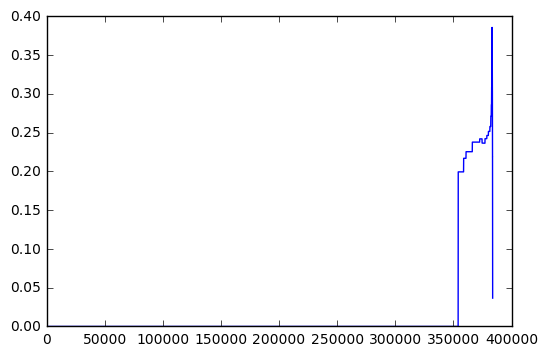

In [13]:
best_proba_val, best_mcc_val, y_pred_val = eval_mcc(dval.get_label(), roundn(bst.predict(dval), 100), show=True)

Feature importance

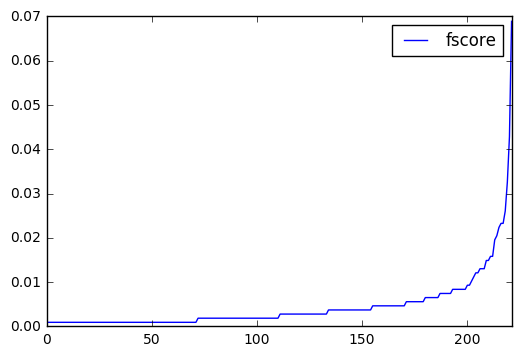

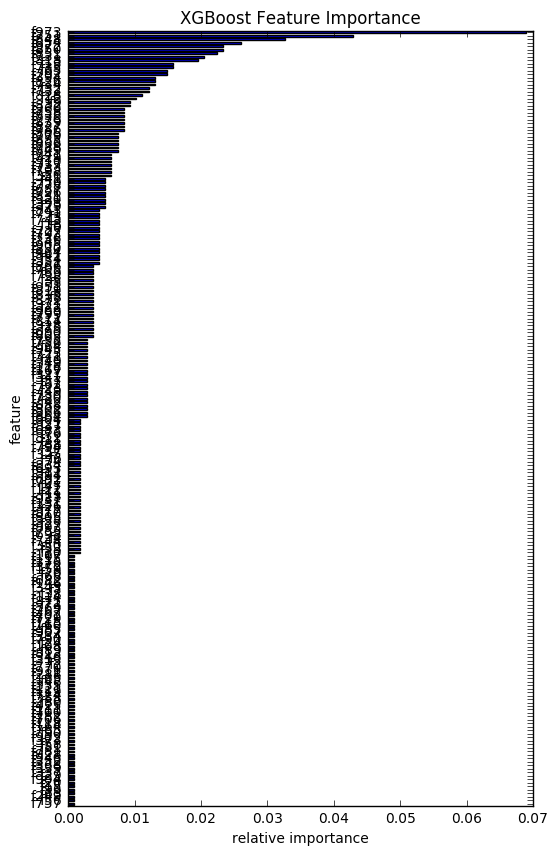

In [14]:
import operator

importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pandas.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

Check ratio of positive in predictions

In [15]:
y_pred_val.sum()/y_pred_val.size

0.0012039182065266959

Check ration of positive in true labels

In [16]:
label=dval.get_label()
label.sum()/label.size

0.0058163321146484535

In [17]:
best_proba_val

0.49000001

### Test

In [18]:
num_round=40
bst = xgb.train( params, dtrain, num_round)

In [19]:
dtest = xgb.DMatrix('/home/ubuntu/data/svm-format/test_numeric_with_magic.svm')

In [20]:
y_pred_test=roundn(bst.predict(dtest), 100)

In [21]:
results=(y_pred_test >= best_proba_val).astype(int)

In [22]:
results.sum()/results.size

0.0013178480554982986

In [23]:
IDs=pandas.read_csv('/home/ubuntu/Ids.txt')

In [24]:
IDs['Response']=results

In [25]:
IDs.head()

,Id,Response
0,1,0
1,2,0
2,3,0
3,5,0
4,8,0


In [26]:
IDs.to_csv('results.csv', index=False)